In [1]:
# This example demonstrates quantum teleportation using qstack.
# Quantum teleportation is a protocol that transfers the state of a qubit to another qubit using entanglement and classical communication.
# The clifford_min layer is a minimal abstraction layer for Clifford operations, providing essential gates like H, CX, and Pauli gates.
# It is designed for efficient simulation and execution of quantum programs.
import qstack

program = None

In [2]:
%%qstack
@instruction-set: cliffords-min

allocate target:
  allocate shared source:
    ---
    ?? prepare(q=source)
    h shared
    cx shared target
    cx source shared
    h source
  measure
  ?? fix(q=target)
measure

[Kernel(target=QubitId(value='target'), instructions=(Kernel(target=QubitId(value='shared'), instructions=(Kernel(target=QubitId(value='source'), instructions=(Kernel(target=None, instructions=(), callback=ClassicInstruction(name='prepare', parameters={'q': 'source'})), QuantumInstruction(name='h', targets=[QubitId(value='shared')], parameters={}), QuantumInstruction(name='cx', targets=[QubitId(value='shared'), QubitId(value='target')], parameters={}), QuantumInstruction(name='cx', targets=[QubitId(value='source'), QubitId(value='shared')], parameters={}), QuantumInstruction(name='h', targets=[QubitId(value='source')], parameters={})), callback=None),), callback=ClassicInstruction(name='fix', parameters={'q': 'target'})),), callback=None)]

In [3]:
## Prepare the classical callbacks that are needed for the teleportation protocol.
import random

from qstack.instruction_sets.cliffords_min import X, H, Z

# Randomly select an operation (X or H) for state preparation.
op = random.choice([X, H])

# Define a classical callback for state preparation.
def prepare(context, *, q):
    return qstack.Kernel(target=[], instructions=[op(q)])


# Define a classical callback for fixing the teleported state based on measurement outcomes.
def fix(context, *, q):
    m0 = context.consume()  # Consume the first measurement result.
    m1 = context.consume()  # Consume the second measurement result.

    instructions = []
    if m1 == 1:
        instructions.append(Z(q))  # Apply a Z gate if the second measurement is 1.
    if m0 == 1:
        instructions.append(X(q))  # Apply an X gate if the first measurement is 1.

    return qstack.Kernel(target=[], instructions=instructions)



In [4]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific instruction set, and needs the list
# of handlers of the classical callbacks that are used in the program.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

callbacks = create_callbacks(prepare,fix)
machine = local_machine_for(program.instruction_set, callbacks=callbacks)


In [5]:
# Print the name of the operation used for state preparation.
print(op.name)

# A single-shot execution runs the program once and returns the measurement outcomes.
# This is useful for observing the result of a single execution of the quantum program.
# Perform a single-shot execution of the teleportation protocol.
machine.single_shot(program)


h


(0,)

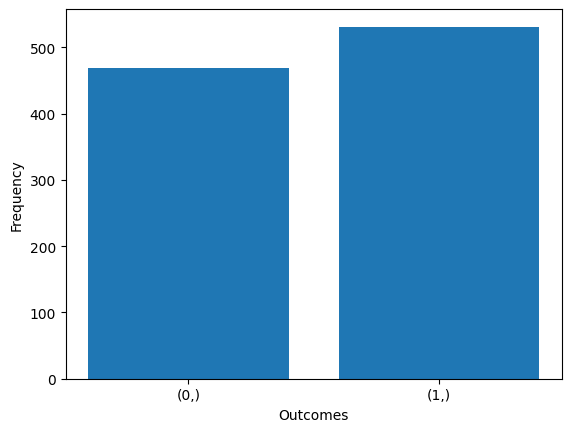

In [6]:
# Evaluate the program multiple times and plot the resulting histogram.
machine.eval(program).plot_histogram()
